In [1]:

!pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-nlp4twd1
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-nlp4twd1
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=272556 sha256=4f5c6e56ec2a04a2b5430583d47d606d32e0a0f2e779fef08c6c15f0a03e9fa9
  Stored in directory: /tmp/pip-ephem-wheel-cache-327zhk2i/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools


In [2]:
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0

Cloning into 'vision'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 19311 (delta 66), reused 19 (delta 0), pack-reused 19212
Receiving objects: 100% (19311/19311), 17.51 MiB | 11.51 MiB/s, done.
Resolving deltas: 100% (14117/14117), done.
/kaggle/working/vision
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [3]:
!cp references/detection/utils.py ../
!cp references/detection/transforms.py ../
!cp references/detection/coco_eval.py ../
!cp references/detection/engine.py ../
!cp references/detection/coco_utils.py ../

In [4]:
%cd ../
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T


DIR = r'/kaggle/input/bolteddataset/train'
csv_path = DIR+'/train.csv'

/kaggle/working


**CREATING DATASET CLASS**

In [5]:
class FlangeDataset(torch.utils.data.Dataset):
    def __init__(self,root,csv_path,transforms=None):
        self.root =root
        self.transforms = transforms
        self.df = pd.read_csv(csv_path)
        self.imgs = list(sorted(os.listdir(os.path.join(root,"images"))))

    def __getitem__(self,idx):
        img_path = os.path.join(self.root,"images",self.imgs[idx])
        PILimg = Image.open(img_path).convert("RGB")
        img = img_path.split('/')[-1]
        rows = self.df.loc[self.df['filename']==img]
        num_objs = len(rows)
        bbox = []
        label_list = []
        target = {}
        if num_objs>0:
            #get bounding box 
            xmin = rows['xmin'].values
            xmax = rows['xmax'].values
            ymin = rows['ymin'].values
            ymax = rows['ymax'].values
            labels = rows['class'].values
            target["iscrowd"] = torch.ones((num_objs,), dtype=torch.int64)
            for i in range(len(xmin)):
                bbox.append([xmin[i],ymin[i],xmax[i],ymax[i]])
                if labels[i]=='bolted':
                    label_list.append(1)
                else:
                    label_list.append(2)
        else:
            bbox.append([0,0,0.1,0.1])
            label_list.append(0)
            target["iscrowd"] = torch.ones((1,), dtype=torch.int64)
            #convert to tensors
        boxes = torch.as_tensor(bbox,dtype=torch.float32)
        labels = torch.as_tensor(label_list,dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        #torch.as_tensor(height*width,dtype=torch.float32)

        
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        

        if self.transforms is not None:
            PILimg,target = self.transforms(PILimg,target)
        return PILimg,target
    def __len__(self):
        return len(self.imgs)


Add transformations which can e useful to add data augmentation at a later stage

In [6]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Creating a display function which will show model predictions on images in a grid

In [7]:
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2

def DisplayResults(model,dataset_test):


    image_datas = []
    for img,_ in dataset_test:
        #img, _ = dataset_test[4]
        # put the model in evaluation mode
        model.eval()
        with torch.no_grad():
            prediction = model([img.to(device)])

        im = transforms.ToPILImage()(img).convert("RGB")
        prediction2 = torchvision.ops.nms(prediction[0]['boxes'],scores=prediction[0]['scores'],iou_threshold=0.3)
        indices = prediction2.tolist()
        bboxes = prediction[0]['boxes'].tolist()
        labels = prediction[0]['labels'].tolist()
        scores = prediction[0]['scores'].tolist()
        threshold = 0.5
        open_cv_image = np.array(im)
        open_cv_image = open_cv_image[:, :, ::-1].copy() 
        for index in indices:
            if scores[index]>threshold :
                box = bboxes[index]
                xmin = int(box[0])
                ymin = int(box[1])
                xmax = int(box[2])
                ymax=int(box[3])    
                cv2.rectangle(open_cv_image,(xmin,ymin),(xmax,ymax),(255,0,0),2)
                if labels[index]==1:
                    label_text = '1'
                else:
                    label_text='2'
                cv2.putText(open_cv_image,label_text,(xmin,ymin-5),cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(255,0,0),2)
        image_datas.append(open_cv_image)
        #plt.imshow(open_cv_image)

    while True:
        if len(image_datas)<20:
            image_datas.append(image_datas[0])
        else:
            break
        

    f, axarr = plt.subplots(5,4,figsize=(15,15))
    axarr[0,0].imshow(image_datas[0])
    axarr[0,1].imshow(image_datas[1])
    axarr[0,2].imshow(image_datas[2])
    axarr[0,3].imshow(image_datas[3])

    axarr[1,0].imshow(image_datas[4])
    axarr[1,1].imshow(image_datas[5])
    axarr[1,2].imshow(image_datas[6])
    axarr[1,3].imshow(image_datas[7])

    axarr[2,0].imshow(image_datas[8])
    axarr[2,1].imshow(image_datas[9])
    axarr[2,2].imshow(image_datas[10])
    axarr[2,3].imshow(image_datas[11])

    axarr[3,0].imshow(image_datas[12])
    axarr[3,1].imshow(image_datas[13])
    axarr[3,2].imshow(image_datas[14])
    axarr[3,3].imshow(image_datas[15])

    axarr[4,0].imshow(image_datas[16])
    axarr[4,1].imshow(image_datas[17])
    axarr[4,2].imshow(image_datas[18])
    axarr[4,3].imshow(image_datas[19])

Creating faster RCNN model for training

Parameters:	
pretrained (bool) – If True, returns a model pre-trained on COCO train2017
progress (bool) – If True, displays a progress bar of the download to stderr
num_classes (int) – number of output classes of the model (including the background)
pretrained_backbone (bool) – If True, returns a model with backbone pre-trained on Imagenet
trainable_backbone_layers (int) – number of trainable (not frozen) resnet layers starting from final

In [8]:
dataset = FlangeDataset(DIR,csv_path,get_transform(train=True))
dataset_test = FlangeDataset(r'/kaggle/input/bolteddataset/test',r'/kaggle/input/bolteddataset/test/test.csv',get_transform(train=False))

EPOCHS = 20
LEARNING_RATE = 0.001


# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
test_indices = torch.randperm(len(dataset_test)).tolist()
# evens = list(range(0, len(dataset), 2))
# odds = list(range(1, len(dataset), 2))
dataset = torch.utils.data.Subset(dataset, indices)
dataset_test = torch.utils.data.Subset(dataset_test, test_indices)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2,collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=2,collate_fn=utils.collate_fn)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Whether using GPU or CPU? ",device)

num_classes = 3  #2 classes +1 background
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)

model.to(device)
#construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE,momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.1)
for epoch in range(EPOCHS):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Whether using GPU or CPU?  cuda


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Epoch: [0]  [ 0/65]  eta: 0:01:34  lr: 0.000017  loss: 2.9332 (2.9332)  loss_classifier: 1.6944 (1.6944)  loss_box_reg: 0.3463 (0.3463)  loss_objectness: 0.8482 (0.8482)  loss_rpn_box_reg: 0.0444 (0.0444)  time: 1.4610  data: 0.3343  max mem: 1285
Epoch: [0]  [50/65]  eta: 0:00:02  lr: 0.000797  loss: 1.1442 (1.5785)  loss_classifier: 0.3787 (0.7007)  loss_box_reg: 0.7099 (0.6363)  loss_objectness: 0.0216 (0.2130)  loss_rpn_box_reg: 0.0153 (0.0285)  time: 0.1697  data: 0.0054  max mem: 1629
Epoch: [0]  [64/65]  eta: 0:00:00  lr: 0.001000  loss: 0.8699 (1.4492)  loss_classifier: 0.2858 (0.6171)  loss_box_reg: 0.5690 (0.6332)  loss_objectness: 0.0128 (0.1724)  loss_rpn_box_reg: 0.0141 (0.0265)  time: 0.1781  data: 0.0067  max mem: 1658
Epoch: [0] Total time: 0:00:12 (0.1951 s / it)
creating index...
index created!
Test:  [0/7]  eta: 0:00:01  model_time: 0.0827 (0.0827)  evaluator_time: 0.0282 (0.0282)  time: 0.1923  data: 0.0798  max mem: 1658
Test:  [6/7]  eta: 0:00:00  model_time: 0.06

Epoch: [4]  [ 0/65]  eta: 0:00:17  lr: 0.001000  loss: 0.3773 (0.3773)  loss_classifier: 0.0714 (0.0714)  loss_box_reg: 0.3004 (0.3004)  loss_objectness: 0.0009 (0.0009)  loss_rpn_box_reg: 0.0045 (0.0045)  time: 0.2693  data: 0.0834  max mem: 1658
Epoch: [4]  [50/65]  eta: 0:00:02  lr: 0.001000  loss: 0.3823 (0.3839)  loss_classifier: 0.0896 (0.1037)  loss_box_reg: 0.2356 (0.2646)  loss_objectness: 0.0010 (0.0056)  loss_rpn_box_reg: 0.0063 (0.0099)  time: 0.1781  data: 0.0063  max mem: 1658
Epoch: [4]  [64/65]  eta: 0:00:00  lr: 0.001000  loss: 0.4246 (0.4035)  loss_classifier: 0.1040 (0.1081)  loss_box_reg: 0.2743 (0.2785)  loss_objectness: 0.0023 (0.0052)  loss_rpn_box_reg: 0.0080 (0.0117)  time: 0.1787  data: 0.0060  max mem: 1658
Epoch: [4] Total time: 0:00:11 (0.1775 s / it)
creating index...
index created!
Test:  [0/7]  eta: 0:00:01  model_time: 0.0814 (0.0814)  evaluator_time: 0.0105 (0.0105)  time: 0.1682  data: 0.0748  max mem: 1658
Test:  [6/7]  eta: 0:00:00  model_time: 0.06

Epoch: [8]  [ 0/65]  eta: 0:00:19  lr: 0.000100  loss: 0.2838 (0.2838)  loss_classifier: 0.0829 (0.0829)  loss_box_reg: 0.1915 (0.1915)  loss_objectness: 0.0024 (0.0024)  loss_rpn_box_reg: 0.0070 (0.0070)  time: 0.3000  data: 0.0844  max mem: 1658
Epoch: [8]  [50/65]  eta: 0:00:02  lr: 0.000100  loss: 0.2632 (0.3160)  loss_classifier: 0.0750 (0.0866)  loss_box_reg: 0.1807 (0.2174)  loss_objectness: 0.0015 (0.0030)  loss_rpn_box_reg: 0.0042 (0.0091)  time: 0.1684  data: 0.0053  max mem: 1658
Epoch: [8]  [64/65]  eta: 0:00:00  lr: 0.000100  loss: 0.2787 (0.3137)  loss_classifier: 0.0750 (0.0854)  loss_box_reg: 0.1940 (0.2164)  loss_objectness: 0.0023 (0.0030)  loss_rpn_box_reg: 0.0045 (0.0090)  time: 0.1717  data: 0.0054  max mem: 1658
Epoch: [8] Total time: 0:00:11 (0.1747 s / it)
creating index...
index created!
Test:  [0/7]  eta: 0:00:01  model_time: 0.0826 (0.0826)  evaluator_time: 0.0096 (0.0096)  time: 0.1678  data: 0.0741  max mem: 1658
Test:  [6/7]  eta: 0:00:00  model_time: 0.06

Epoch: [12]  [ 0/65]  eta: 0:00:17  lr: 0.000010  loss: 0.2991 (0.2991)  loss_classifier: 0.0606 (0.0606)  loss_box_reg: 0.2296 (0.2296)  loss_objectness: 0.0020 (0.0020)  loss_rpn_box_reg: 0.0069 (0.0069)  time: 0.2646  data: 0.0952  max mem: 1658
Epoch: [12]  [50/65]  eta: 0:00:02  lr: 0.000010  loss: 0.2323 (0.2986)  loss_classifier: 0.0618 (0.0802)  loss_box_reg: 0.1627 (0.2064)  loss_objectness: 0.0013 (0.0028)  loss_rpn_box_reg: 0.0031 (0.0092)  time: 0.1876  data: 0.0065  max mem: 1658
Epoch: [12]  [64/65]  eta: 0:00:00  lr: 0.000010  loss: 0.2400 (0.2985)  loss_classifier: 0.0812 (0.0815)  loss_box_reg: 0.1633 (0.2059)  loss_objectness: 0.0006 (0.0025)  loss_rpn_box_reg: 0.0040 (0.0087)  time: 0.1690  data: 0.0049  max mem: 1658
Epoch: [12] Total time: 0:00:11 (0.1768 s / it)
creating index...
index created!
Test:  [0/7]  eta: 0:00:01  model_time: 0.0822 (0.0822)  evaluator_time: 0.0088 (0.0088)  time: 0.1626  data: 0.0704  max mem: 1658
Test:  [6/7]  eta: 0:00:00  model_time: 

Epoch: [16]  [ 0/65]  eta: 0:00:16  lr: 0.000001  loss: 0.2927 (0.2927)  loss_classifier: 0.0597 (0.0597)  loss_box_reg: 0.2277 (0.2277)  loss_objectness: 0.0013 (0.0013)  loss_rpn_box_reg: 0.0040 (0.0040)  time: 0.2553  data: 0.0841  max mem: 1658
Epoch: [16]  [50/65]  eta: 0:00:02  lr: 0.000001  loss: 0.2499 (0.2935)  loss_classifier: 0.0748 (0.0790)  loss_box_reg: 0.1670 (0.2032)  loss_objectness: 0.0010 (0.0026)  loss_rpn_box_reg: 0.0041 (0.0087)  time: 0.1638  data: 0.0052  max mem: 1658
Epoch: [16]  [64/65]  eta: 0:00:00  lr: 0.000001  loss: 0.2598 (0.2978)  loss_classifier: 0.0652 (0.0827)  loss_box_reg: 0.1739 (0.2038)  loss_objectness: 0.0004 (0.0026)  loss_rpn_box_reg: 0.0046 (0.0087)  time: 0.1687  data: 0.0053  max mem: 1658
Epoch: [16] Total time: 0:00:11 (0.1750 s / it)
creating index...
index created!
Test:  [0/7]  eta: 0:00:01  model_time: 0.0823 (0.0823)  evaluator_time: 0.0081 (0.0081)  time: 0.1636  data: 0.0717  max mem: 1658
Test:  [6/7]  eta: 0:00:00  model_time: 

torch.Size([3, 194, 259])
torch.Size([3, 202, 250])
torch.Size([3, 167, 300])
torch.Size([3, 225, 225])
torch.Size([3, 225, 225])
torch.Size([3, 350, 350])
torch.Size([3, 252, 236])


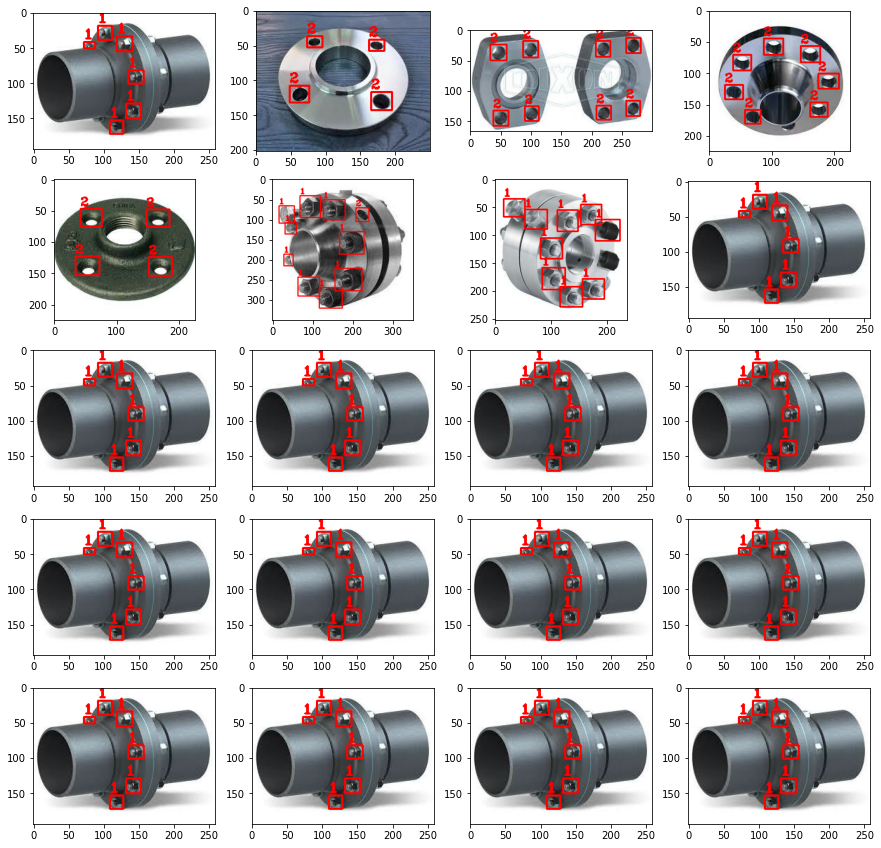

In [9]:
DisplayResults(model,dataset_test)

SAVING THE TRAINED MODEL

In [11]:
CHECKPOINT_PATH = r'model_best'+str(EPOCHS)+'.pt'
LOSS = 0.4 #dummy value

checkpoint = {'model':model,'state_dict':model.state_dict(),'optimizer':optimizer.state_dict()}
torch.save(checkpoint,CHECKPOINT_PATH)

**LOADING THE SAVED MODEL FOR INFERENCE**

torch.Size([3, 194, 259])
torch.Size([3, 202, 250])
torch.Size([3, 167, 300])
torch.Size([3, 225, 225])
torch.Size([3, 225, 225])
torch.Size([3, 350, 350])
torch.Size([3, 252, 236])


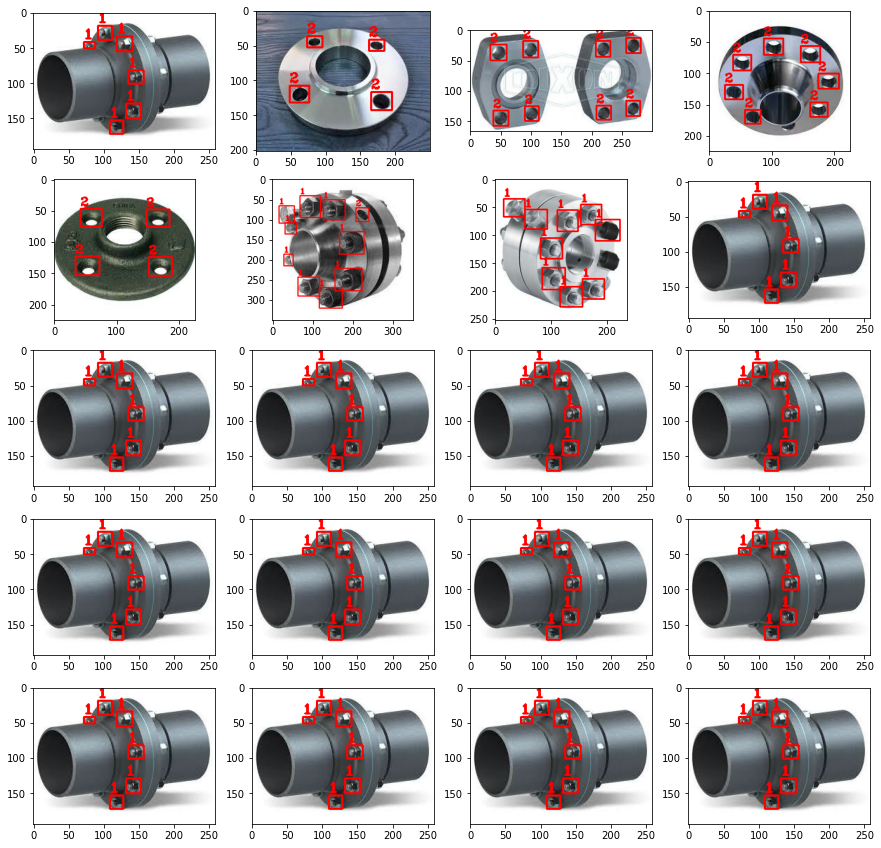

In [12]:
checkpoint = torch.load(CHECKPOINT_PATH,map_location=device)
model_test = checkpoint['model']
model_test.load_state_dict(checkpoint['state_dict'])
DisplayResults(model,dataset_test)

**Creating model with mobilenetv3 backbone **

In [ ]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator


dataset = FlangeDataset(DIR,csv_path,get_transform(train=True))
#dataset_test = FlangeDataset(DIR,csv_path,get_transform(train=False))
dataset_test = FlangeDataset(r'/kaggle/input/bolteddataset/test',r'/kaggle/input/bolteddataset/test/test.csv',get_transform(train=False))

EPOCHS = 20
LEARNING_RATE = 0.001


# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
test_indices = torch.randperm(len(dataset_test)).tolist()
# evens = list(range(0, len(dataset), 2))
# odds = list(range(1, len(dataset), 2))
dataset = torch.utils.data.Subset(dataset, indices)
dataset_test = torch.utils.data.Subset(dataset_test, test_indices)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2,collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=2,collate_fn=utils.collate_fn)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Whether using GPU or CPU? ",device)

backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs


roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

mobilenet = FasterRCNN(backbone,
                   num_classes=3,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2,collate_fn=utils.collate_fn)
mobilenet.to(device)
mparams = [p for p in mobilenet.parameters() if p.requires_grad]
moptimizer = torch.optim.SGD(mparams, lr=LEARNING_RATE,momentum=0.9, weight_decay=0.0005)

mlr_scheduler = torch.optim.lr_scheduler.StepLR(moptimizer,step_size=5,gamma=0.1)
for epoch in range(EPOCHS):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(mobilenet, moptimizer, data_loader, device, epoch, print_freq=50)
    # update the learning rate
    mlr_scheduler.step()
    # evaluate on the test dataset
    evaluate(mobilenet, data_loader_test, device=device)

